In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, LambdaCallback, EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, confusion_matrix

2023-03-09 17:59:30.091530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
grb = ["2021-08-07_10-05-18_exp4s_sbin4/ch0/part1/rate_multi_ch.txt",
"2021-08-22_09-16-56_exp4s_sbin4/ch0/part1/rate_multi_ch.txt",
"2021-09-09_09-25-05_exp4s_sbin4/ch0/part2/rate_multi_ch.txt",
"2021-10-18_22-22-36_exp1s_sbin4/ch0/part1/rate_multi_ch.txt",
"2021-10-18_22-22-36_exp1s_sbin4/ch0/part2/rate_multi_ch.txt"]

uno = glob.glob("Data/GRBalpha/Data_firmware_2/*-*-*_*-*-*_exp*s_sbin*/ch0/part*/rate_multi_ch.txt")
dos = glob.glob("Data/GRBalpha/Data_firmware_3/*-*-*_*-*-*_exp*s_sbin*/ch0/rate_multi_ch.txt")
data = np.sort(dos)
X = []
fill = []
for fname in data:
    if fname in grb:
        skip
    else:
        with open(fname) as file:
            fill.append(fname)
            lines = file.readlines()
            for line in lines[9:]:
                split = line[:-1].split()
                X.append([float(split[7]),float(split[8]),np.log10(float(split[-1])+1)])
                


            
print(len(uno),len(dos))
print("Number of files:",len(data))
print("Number of points:",len(X))

df = pd.DataFrame(data = X, columns=["log","lat","rate"])
df

522 54
Number of files: 54
Number of points: 463779


,log,lat,rate
0,354.1160,48.1902,2.193820
1,354.0260,47.9446,2.186815
2,353.9370,47.6989,2.183981
3,353.8490,47.4532,2.203441
4,353.7610,47.2074,2.163609
...,...,...,...
463774,82.9377,-54.1543,3.013680
463775,82.9098,-54.2151,2.993877
463776,82.8819,-54.2759,2.980912
463777,82.8539,-54.3368,2.984527


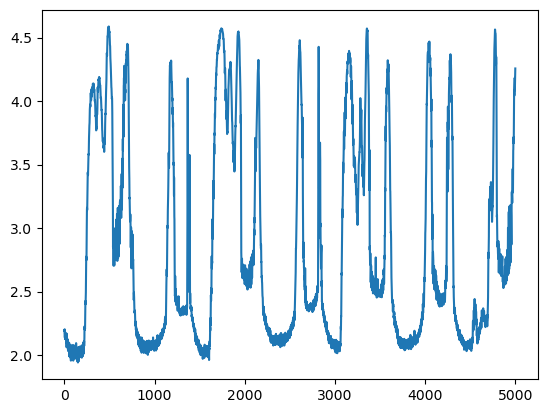

In [3]:
plt.plot(df["rate"][0:5000])

In [4]:
df['rate'].to_numpy()

array([2.19382003, 2.18681512, 2.18398122, ..., 2.98091194, 2.98452731,
       2.59988307])

In [5]:
def df_to_X_y(df, window_size=10):
  df_as_np = df.to_numpy()
  X,y = [], []
  for i in range(len(df_as_np)-window_size):
    X.append(df_as_np[i:i+window_size])
    y.append(df['rate'][i+window_size])
  return np.array(X), np.array(y)

In [6]:
WINDOW_SIZE = 20
X1, y1 = df_to_X_y(df, WINDOW_SIZE)
X1.shape, y1.shape

((463759, 20, 3), (463759,))

In [7]:
X_train, y_train, X_test, y_test = X1[0:400000],y1[0:400000],X1[400000:],y1[400000:]

In [8]:
model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, 3)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

2023-03-09 17:59:50.057295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 17:59:50.057729: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,937
Trainable params: 17,937
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=RootMeanSquaredError())
model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Epoch 1/5
 8126/12500 [==================>...........] - ETA: 1:51 - loss: 0.1756 - root_mean_squared_error: 0.4191

# GRBalpha (true) detections

In [ ]:
X_grb = []


uno = glob.glob("Data/GRBalpha/Data_firmware_2/*-*-*_*-*-*_exp*s_sbin*/ch0/part*/rate_multi_ch.txt")
for fname in uno:
    with open(fname) as file:
        lines = file.readlines()
        for line in lines[9:]:
            print(line)
            split = line[:-1].split()
            X_grb.append([float(split[7]),float(split[8]),np.log10(float(split[-1])+1)])


df_grb = pd.DataFrame(data = X_grb, columns=["log","lat","rate"])
df_grb

In [ ]:
WINDOW_SIZE = 20
X1, y1 = df_to_X_y(df_grb, WINDOW_SIZE)
test_predictions = model1.predict(X1).flatten()
plt.plot(10**(test_predictions))
plt.plot(10**y1)

In [ ]:
plt.plot(10**(test_predictions[4500:5000]))
plt.plot(10**y1[4500:5000])

In [ ]:
plt.plot(10**(test_predictions[50000:75000]))
plt.plot(10**y1[50000:75000])

In [ ]:
pred = 10**test_predictions
truee = 
plt.plot

In [ ]:
what_time = []
with open('Data/GRBalpha/outliers/2022-08-14_21-30-12_exp4.000000s_sbin16/ch0/rate_multi_ch.txt') as file:
    lines = file.readlines()
    for line in lines[15330:15430]:
        split = line[:-1].split()
        what_time.append([split[4],split[5]])

what_time